<a href="https://colab.research.google.com/github/shishir2sr/ARKit-By-Example/blob/main/LCC_Image_Mask_UNET_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow
!pip uninstall keras

Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.16.2
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.4.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-3.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/Colab Datasets/'

In [ ]:
!pip install tensorflow==2.15.1
!pip install tf-keras
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2


In [ ]:
!pip install patchify

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imageio


In [ ]:
# Load Images

def load_image(image_path, mask_path, img_size=(256, 256)):
    # Load the original image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]


    # Load the mask image
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32)

    # Normalize mask to binary (0 and 1) - set all non-zero values to 1
    mask = tf.where(mask > 0.0, 1.0, 0.0)

    return img, mask


In [ ]:

# Create Dataset
def create_dataset(image_folder, mask_folder, img_size=(256, 256), batch_size=32):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.png')])

    # Dataset Create
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: load_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


In [ ]:
image_data_path = drive_path + 'X_TRAIN_LCC'
mask_data_path = drive_path + 'Y_TRAIN_LCC'

dataset = create_dataset(image_data_path, mask_data_path)


In [ ]:
#Plot
show_random_samples(dataset, num_samples=1)

NameError: name 'show_random_samples' is not defined

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [ ]:
# Initialize lists to collect all images and masksimages = []
masks = []
images = []

# Iterate through the dataset and collect all images and masks
for image_batch, mask_batch in dataset.as_numpy_iterator():
    images.append(image_batch)
    masks.append(mask_batch)

# Concatenate all batches into single arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

print("All images shape:", images.shape)
print("All masks shape:", masks.shape)


All images shape: (158, 256, 256, 3)
All masks shape: (158, 256, 256, 1)


In [ ]:
images1=preprocess_input1(images)
print(images1.shape)

(158, 256, 256, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

(118, 256, 256, 3)
(40, 256, 256, 3)


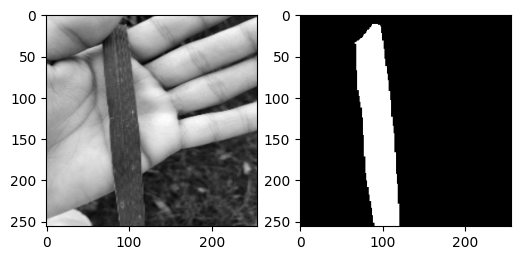

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

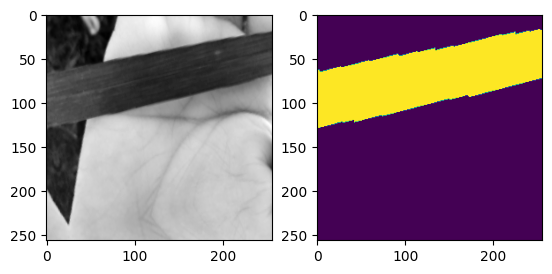

In [ ]:
x = next(image_generator)
y = next(mask_generator)
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50)
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=20)

Epoch 1/50
50/50 [==============================] - 81s 2s/step - loss: 0.2140 - iou_score: 0.8355 - val_loss: 1.5784 - val_iou_score: 0.0442
Epoch 2/50
50/50 [==============================] - 60s 1s/step - loss: 0.2479 - iou_score: 0.8752 - val_loss: 1.6870 - val_iou_score: 0.0312
Epoch 3/50
50/50 [==============================] - 77s 2s/step - loss: 0.2317 - iou_score: 0.8805 - val_loss: 3.1645 - val_iou_score: 0.1944
Epoch 4/50
50/50 [==============================] - 61s 1s/step - loss: 0.2441 - iou_score: 0.8860 - val_loss: 2.4316 - val_iou_score: 0.2057
Epoch 5/50
50/50 [==============================] - 78s 2s/step - loss: 0.2480 - iou_score: 0.8746 - val_loss: 2.1964 - val_iou_score: 0.0024
Epoch 6/50
50/50 [==============================] - 69s 1s/step - loss: 0.2496 - iou_score: 0.8870 - val_loss: 2.2691 - val_iou_score: 0.0988
Epoch 7/50
50/50 [==============================] - 76s 2s/step - loss: 0.2306 - iou_score: 0.8871 - val_loss: 2.3976 - val_iou_score: 0.2130
Epoch 

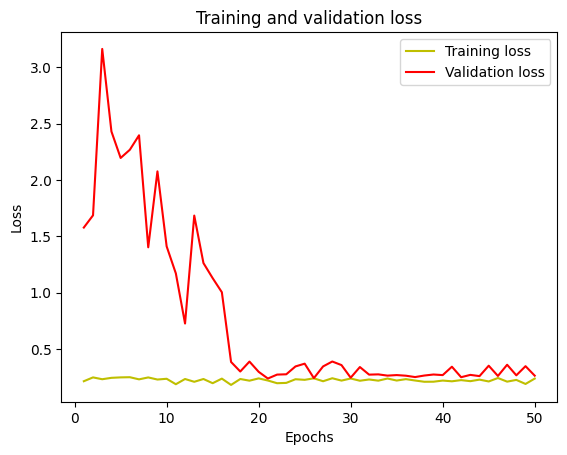

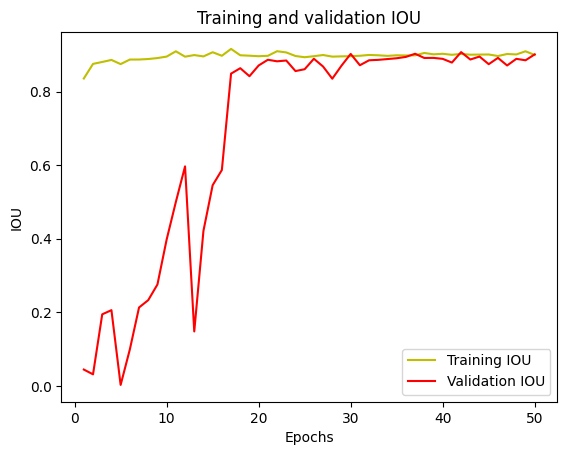

2/2 [==============================] - 0s 165ms/step
IoU socre is:  0.9642586868526488
1/1 [==============================] - 0s 36ms/step


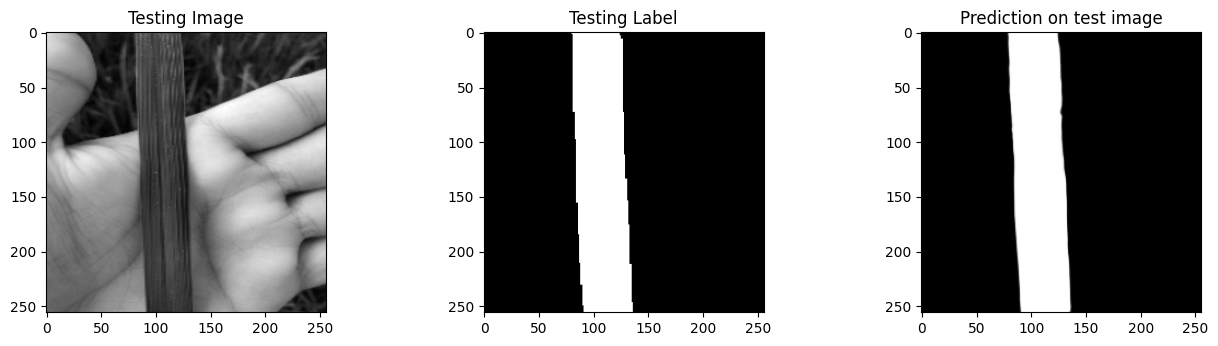

In [ ]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()



In [ ]:
import datetime
current_time = datetime.datetime.now()
formatted_time = current_time.strftime('%d%m%Y_%H%M')
model_name = f'lcc_segmentation_{formatted_time}.h5'
save_path = drive_path + 'models/' + model_name
model.save(save_path)



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Define the custom loss function and metric within a custom object scope
with tf.keras.utils.custom_object_scope({'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss, 'iou_score': sm.metrics.iou_score}):
    model = tf.keras.models.load_model(drive_path + 'models/lcc_segmentation_03072024_1034.h5')

# Convert the Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Save to drive
model_save_path = drive_path + '/models/LCC_Tflite_model.tflite'

# Save the TFLite model to a file
with open(model_save_path, 'wb') as f:
    f.write(tflite_model)
